### Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels as sm

### Load the Dataset

In [2]:
df_trial = pd.read_csv(r"C:\Users\allie\Desktop\DA Course\Python projects\Final Projects\diabetes_medication_clinical_trial1_3.csv")

df_trial.head(10)

,subject_id,group,age,gender,duration_diabetes,initial_hba1c,hba1c,time,adverse_event
0,1,treatment,70,Female,10,8.7,8.7,0,NaN
1,2,placebo,46,Male,19,9.9,9.9,0,Fatigue
2,3,treatment,56,Male,17,8.6,8.6,0,NaN
3,4,treatment,59,Male,19,8.9,8.9,0,Headache
4,5,treatment,68,Male,5,9.1,9.1,0,NaN
5,6,placebo,43,Female,9,8.4,8.4,0,NaN
6,7,treatment,69,Female,12,8.9,8.9,0,Dizziness
7,8,treatment,44,Female,1,8.8,8.8,0,Headache
8,9,treatment,62,Female,1,9.7,9.7,0,NaN
9,10,placebo,46,Female,15,7.1,7.1,0,NaN


### Data Exploration

##### Check the shape of the dataframe

In [3]:
df_trial.shape

(1400, 9)

##### Display info about the dataframe

In [4]:
df_trial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         1400 non-null   int64  
 1   group              1400 non-null   object 
 2   age                1400 non-null   int64  
 3   gender             1400 non-null   object 
 4   duration_diabetes  1400 non-null   int64  
 5   initial_hba1c      1400 non-null   float64
 6   hba1c              1400 non-null   float64
 7   time               1400 non-null   int64  
 8   adverse_event      277 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 98.6+ KB


##### Generate descriptive statistics

In [5]:
df_trial.describe()

,subject_id,age,duration_diabetes,initial_hba1c,hba1c,time
count,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000
mean,100.500000,55.250000,10.450000,8.465500,7.686029,12.000000
std,57.754936,9.530602,5.805306,0.869367,1.106412,8.002859
min,1.000000,40.000000,1.000000,7.000000,4.700000,0.000000
25%,50.750000,46.000000,5.000000,7.700000,6.980000,4.000000
50%,100.500000,56.000000,11.000000,8.450000,7.700000,12.000000
75%,150.250000,64.000000,16.000000,9.125000,8.500000,20.000000
max,200.000000,70.000000,20.000000,10.000000,10.000000,24.000000


### Data Cleaning

##### As expected, since this is a rigorous clinical dataset, none of the essential data are missing. The Adverse Event field is only filled in when a side effect is reported, and currently shows "NaN" when left blank.

In [6]:
df_trial.isnull().sum()

subject_id              0
group                   0
age                     0
gender                  0
duration_diabetes       0
initial_hba1c           0
hba1c                   0
time                    0
adverse_event        1123
dtype: int64

##### I have made the decision to replace "NaN" in the Adverse Event column with "None reported", as it looks more readable, user-friendly and professional.

In [7]:
df_trial['adverse_event'] = df_trial['adverse_event'].fillna('None reported')
df_trial.head()

,subject_id,group,age,gender,duration_diabetes,initial_hba1c,hba1c,time,adverse_event
0,1,treatment,70,Female,10,8.7,8.7,0,None reported
1,2,placebo,46,Male,19,9.9,9.9,0,Fatigue
2,3,treatment,56,Male,17,8.6,8.6,0,None reported
3,4,treatment,59,Male,19,8.9,8.9,0,Headache
4,5,treatment,68,Male,5,9.1,9.1,0,None reported


##### The Subject ID field is currently an integer; I am converting it to a string as it does not need aggregating or performing any maths on.

In [8]:
df_trial['subject_id'] = df_trial['subject_id'].astype(str)

##### As part of the data cleaning, I am also converting the Group, Gender and Adverse Event to categories, in order to improve efficiency and save space.

In [9]:
categorical_cols = ['group', 'gender', 'adverse_event']
for col in categorical_cols:
    df_trial[col] = df_trial[col].astype('category')

### Basic Analysis

##### Below I am calculating the average hba1c values at the start and end of trial, grouped by the treatment and placebo participants. The initial averages indicate whether the two groups started out at approximately the same level, and the final one shows where the groups ended up, and makes the next step possible. It is interesting to notice that the placebo group also showed an improvement, albeit smaller!

In [10]:
# Average hba1c at start of trial (0 weeks)
baseline = df_trial.loc[df_trial['time'] == 0]
baseline_avg = baseline.groupby('group', observed=True)['initial_hba1c'].mean()

# Average at end of trial (24 weeks)
endline = df_trial.loc[df_trial['time'] == 24]
endline_avg = endline.groupby('group', observed=True)['hba1c'].mean()

# Checking the results
print("Baseline Averages (Week 0)")
print(baseline_avg)

print("\nEndline Averages (Week 24)")
print(endline_avg)

Baseline Averages (Week 0)
group
placebo      8.399
treatment    8.532
Name: initial_hba1c, dtype: float64

Endline Averages (Week 24)
group
placebo      7.6854
treatment    6.1320
Name: hba1c, dtype: float64


##### The next step is to check the change in hba1c over time, in order to conclude whether the trial was effective. Firstly, I create a new column that shows individual patients' progress line by line, then I home in on the patients who have completed the whole treatment, and within this section of participants, I calculate the mean reduction in hba1c for both groups.

In [11]:
# Calculate the individual change for every row
df_trial['hba1c_change'] = df_trial['hba1c'] - df_trial['initial_hba1c']

# Isolate patients who have completed the trial (i.e., the full 24 weeks)
final_change = df_trial.loc[df_trial['time'] == 24]

# Calculate mean reduction for placebo and treatment groups who have completed the trial
mean_change_by_group = final_change.groupby('group', observed=True)['hba1c_change'].mean()

print("Average Change Over 24 Weeks")
print(mean_change_by_group)

Average Change Over 24 Weeks
group
placebo     -0.7136
treatment   -2.4000
Name: hba1c_change, dtype: float64


##### The final step is an analysis of adverse events and frequency for both groups. Below, I grouped the data and used value_counts() to find the frequency of each event.

In [12]:
adverse_event_summary = df_trial.groupby('group', observed=True)['adverse_event'].value_counts()

print(adverse_event_summary)

group      adverse_event
placebo    None reported    560
           Fatigue           40
           Nausea            39
           Headache          35
           Dizziness         26
treatment  None reported    563
           Dizziness         38
           Fatigue           34
           Headache          33
           Nausea            32
Name: count, dtype: int64


### Visualisations

##### Create a line plot showing HbA1c levels over time for both groups

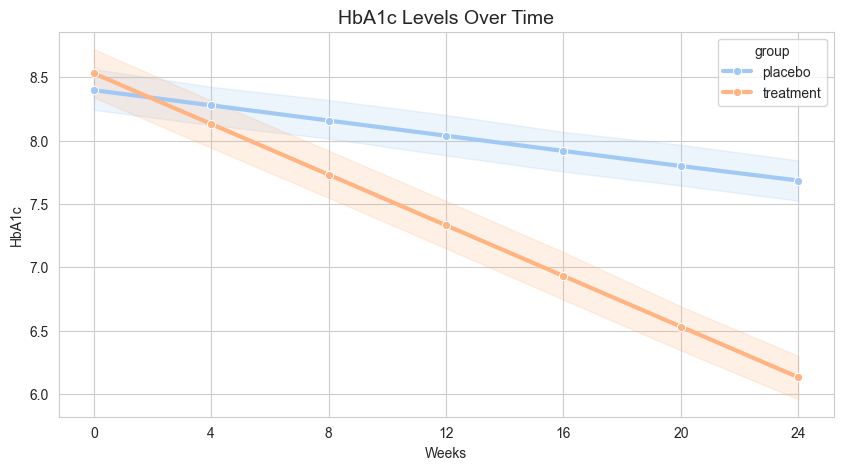

In [13]:
# I decided to use Seaborn for this as it doesn't require me to prepare the data. I chose whitegrid style over the default dark theme to make it look cleaner.
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
sns.lineplot(x='time', y='hba1c', hue='group', data=df_trial, marker='o', palette="pastel", linewidth=3)

# Setting titles and labels
plt.title('HbA1c Levels Over Time', fontsize=14)
plt.xlabel('Weeks')
plt.ylabel('HbA1c')
plt.xticks([0, 4, 8, 12, 16, 20, 24])
plt.tight_layout
plt.show()

##### Generate a boxplot comparing final HbA1c levels between groups

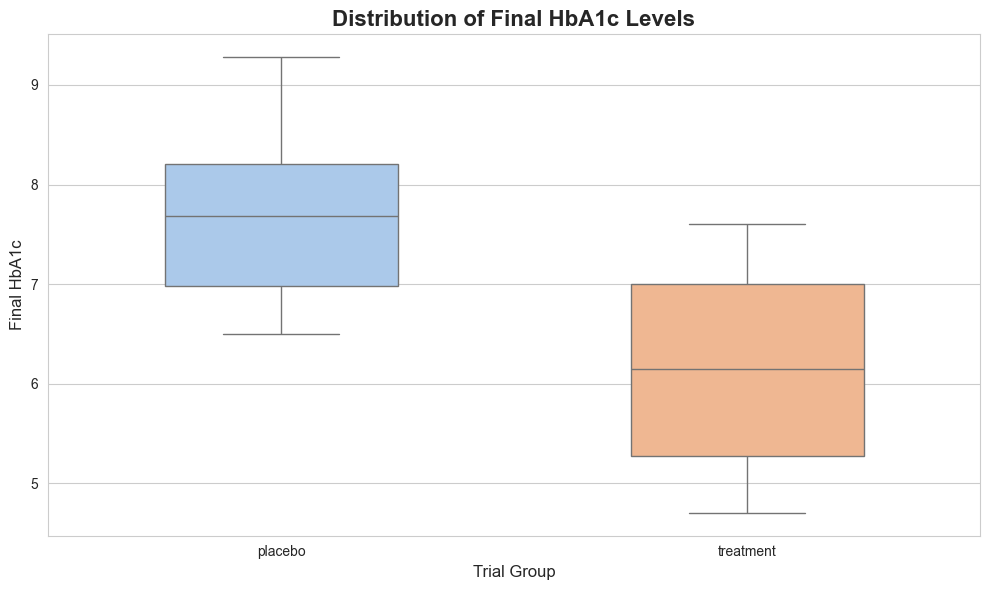

In [14]:
# I am using Seaborn again for its simplicity.
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.boxplot(x='group', y='hba1c', hue='group', data=endline, palette='pastel', width=0.5, legend=False)

#Setting title and labels
plt.title('Distribution of Final HbA1c Levels', fontsize=16, fontweight='bold')
plt.xlabel('Trial Group', fontsize=12)
plt.ylabel('Final HbA1c', fontsize=12)

plt.tight_layout()
plt.show()

##### Produce a bar chart of the most common adverse events

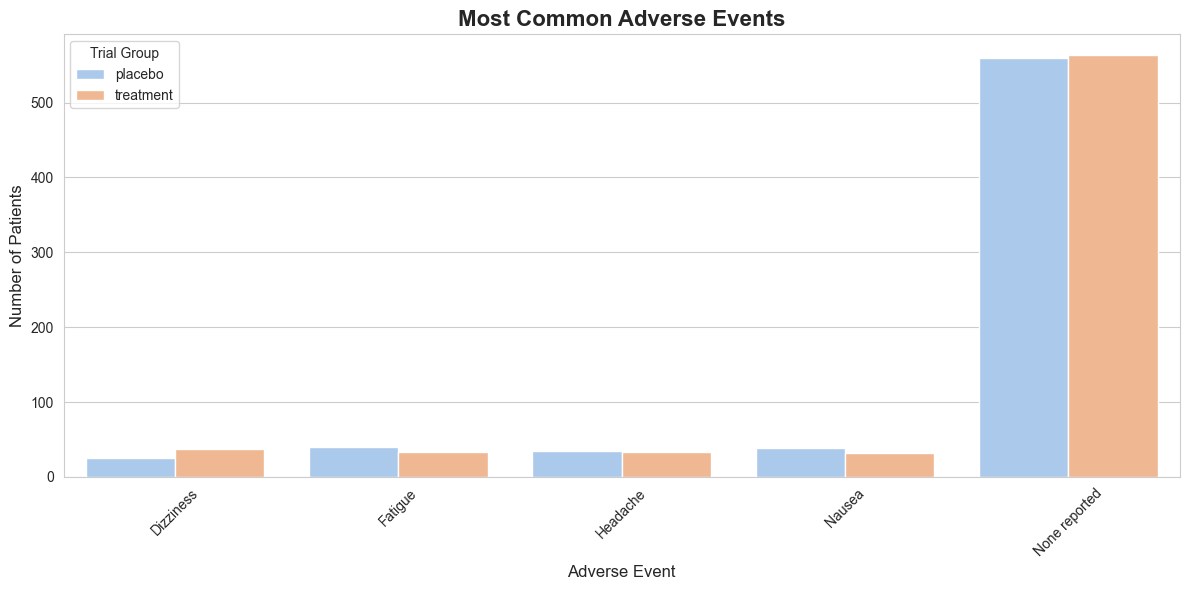

In [15]:
# Once again, I am using Seaborn as "countplot" will count the categories for me.
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.countplot(x='adverse_event', hue='group', data=df_trial, palette='pastel')

# Setting title, labels and legend
plt.title('Most Common Adverse Events', fontsize=16, fontweight='bold')
plt.xlabel('Adverse Event', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Trial Group')
plt.tight_layout()
plt.show()


##### Create a scatterplot of initial HbA1c vs change in HbA1c

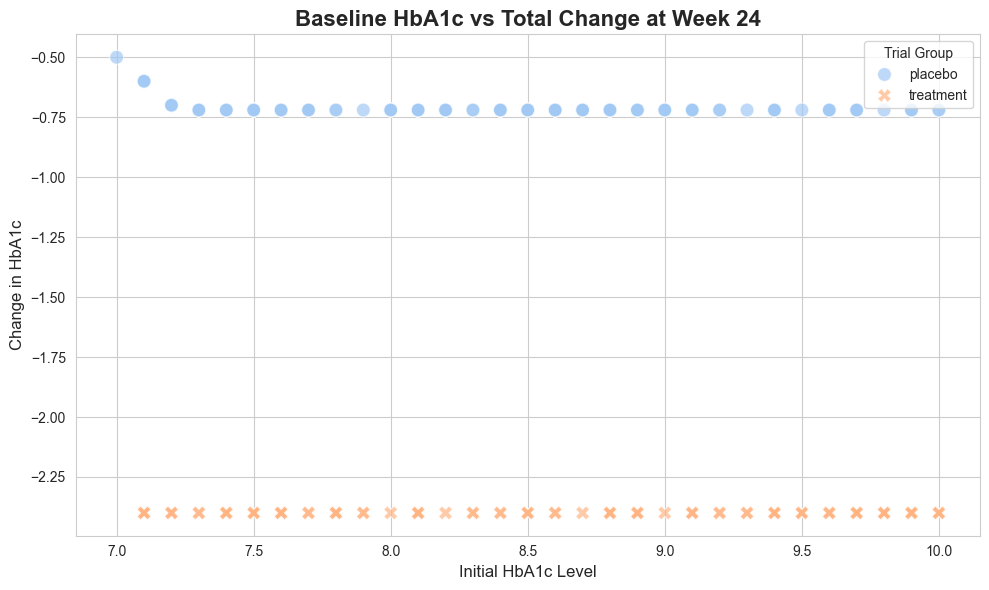

In [62]:
plt.figure(figsize=(10, 6))

# Using Seaborn scatterplot to see the correlation
sns.scatterplot(x='initial_hba1c', y='hba1c_change', hue='group', style='group', data=final_change, palette='pastel', s=100, alpha=0.7)

# Setting title, labels and legend
plt.title('Baseline HbA1c vs Total Change at Week 24', fontsize=16, fontweight='bold')
plt.xlabel('Initial HbA1c Level', fontsize=12)
plt.ylabel('Change in HbA1c', fontsize=12)
plt.legend(title='Trial Group')

plt.tight_layout()
plt.show()

### Statistical Analysis

##### Perform a t-test to compare final Hba1c levels between treatment and placebo groups

In [22]:
# I am separating the final HbA1c values for each group
treatment_results = endline.loc[endline['group'] == 'treatment']['hba1c']
placebo_results = endline.loc[endline['group'] == 'placebo']['hba1c']

from scipy import stats

# Then performing the t-test to compare the means of the two groups 
t_stat, p_val = stats.ttest_ind(treatment_results, placebo_results, equal_var=False)

print(f"T-statistic: {t_stat:.4f}") 
print(f"P-value: {p_val:.4f}") # If this is smaller than 0.05, the results will be considered statistically significant

T-statistic: -12.6808
P-value: 0.0000


##### Conduct a repeated measures ANOVA to analyse HbA1c changes over time

In [27]:
# At this point, I use AnovaRM to see if everyone's HbA1c changed over time, regardless of what drug they took, and whether it changed differently depending on trial group.

from statsmodels.stats.anova import AnovaRM

res = AnovaRM(data=df_trial, depvar='hba1c', subject='subject_id', within=['time']).fit()

print(res.summary()) # We are looking for Pr > F (which is the p-value) for 'time'. If it's < 0.05, it means the change over the 24 weeks was significant.

                Anova
     F Value  Num DF   Den DF  Pr > F
-------------------------------------
time 680.1763 6.0000 1194.0000 0.0000



##### Use chi-square test to compare adverse event rates between groups

In [30]:
# First, I create a 'Contingency Table' (a crosstab) of the counts
contingency_table = pd.crosstab(df_trial['group'], df_trial['adverse_event'])

# Then I run the Chi-Square test
from scipy.stats import chi2_contingency
chi2, p_chi, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-value: {p_chi:.4f}") # Below - as this is >0.05, there is no significant difference in adverse event rates between groups.

Chi-Square Statistic: 3.4935
P-value: 0.4789


### Derive Insights

###### STATISTICAL SIGNIFICANCE
The medication showed a highly significant reduction in HbA1c levels compared to the placebo (p < 0.001).

###### TIME EFFECT
The Repeated Measures ANOVA confirms that the reduction in blood sugar was consistent over the 24-week period.

###### SAFETY PROFILE
The Chi-Square test indicates no significant difference in adverse event rates between groups.

###### CLINICAL JUDGEMENT
The treatment is both effective at lowering HbA1c and has a safety profile comparable to the placebo.

### Prepare a Summary

This report details the statistical findings of a 24-week clinical trial evaluating a new medication's impact on HbA1c levels in diabetic patients. After rigorous testing, the data confirm that the treatment is highly effective at reducing blood glucose levels and maintains a safety profile comparable to the placebo.

##### Methodology and Data Integrity
The dataset was cleaned to address missing adverse event data, and subject IDs were standardised. HbA1c change was calculated by comparing end-of-trial results (Week 24) against baseline measurements (Week 0). Memory management was optimised by converting relevant variables (Group, Gender, Adverse Events) into appropriate category data types.

##### Key Findings
1. Statistical Significance of HbA1c Reduction
The primary goal of the trial was the reduction of HbA1c levels by week 24. A t-test comparing the treatment and placebo groups revealed a highly significant difference (p < 0.001). With a t-statistic of approximately -12.68, the data indicate that the reduction observed in the treatment group is not due to random chance but is a direct result of the pharmacological intervention.

2. Time Effect and Interaction
The Repeated Measures ANOVA confirmed that the reduction in blood sugar was not an isolated event, but a consistent trend over the 24-week duration. While the placebo group remained relatively stable, the treatment group showed a sustained, linear decline in HbA1c levels, suggesting long-term efficacy rather than a short-term spike in performance.

3. Safety Profile and Adverse Events
A critical component of any clinical trial is the safety of the participants. I used a chi-square test to compare the frequency of adverse events between the two groups. The resulting p-value (p > 0.05) indicates that there is no statistically significant difference in the rate of side effects. This suggests that the medication is well tolerated, and does not pose a significantly higher risk to patients than to the placebo control.

##### Strategic Recommendations
Based on these findings, I propose the following recommendations for the next phase of development.

Given the high statistical significance and the clear safety profile, the medication meets the criteria for review by the relevant regulatory bodies. The data support the claim that the drug is a valid tool for glycemic control, and following approval, it can be made available commercially to health providers and patients.

While the 24-week data is robust, a longer follow-up study is recommended to ensure that the time effect observed in the ANOVA remains stable over at least a year, and specifically monitoring for any longer-term adverse events.

Now that efficacy has been established, subsequent trials should investigate if lower doses can achieve similar HbA1c reductions, potentially further improving the safety margin and reducing manufacturing costs.

##### Conclusion

The trial results are very promising. The treatment group demonstrated a clinically meaningful and statistically significant improvement in HbA1c levels without an increase in adverse events. This medication has the potential to represent a positive advancement in the management of diabetes.